In [1]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "1" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

import matplotlib 
if not is_notebook():
    matplotlib.use('Agg')

In [2]:
import os
import math
import json
import random as rnd
from typing import Optional, Callable
from tqdm import tqdm
from collections import defaultdict
from functools import partial
from datetime import datetime
from dataclasses import dataclass 
from itertools import product

from omegaconf import OmegaConf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import matplotlib.pyplot as plt
import pandas as  pd
import torchvision.utils as vision_utils
from PIL import Image
import torchvision
from torchvision import transforms
from matplotlib.ticker import NullFormatter
from sklearn.decomposition import PCA

from losses.divdis import DivDisLoss 
from losses.divdis import DivDisLoss
from losses.ace_uncertain import ACELoss
from losses.conf import ConfLoss
from losses.dbat import DBatLoss
from losses.pass_through import PassThroughLoss
from losses.smooth_top_loss import SmoothTopLoss
from losses.loss_types import LossType

# from models.backbone import MultiHeadBackbone
from models.multi_model import MultiNetModel, freeze_heads
from models.lenet import LeNet

from spurious_datasets.cifar_mnist import get_cifar_mnist_datasets
from spurious_datasets.fmnist_mnist import get_fmnist_mnist_datasets
from spurious_datasets.toy_grid import get_toy_grid_datasets
from spurious_datasets.waterbirds import get_waterbirds_datasets
from spurious_datasets.cub import get_cub_datasets
from spurious_datasets.camelyon import get_camelyon_datasets
from spurious_datasets.multi_nli import get_multi_nli_datasets
from spurious_datasets.civil_comments import get_civil_comments_datasets
from spurious_datasets.celebA import get_celebA_datasets

from utils.utils import to_device, batch_size, feature_label_ls
from utils.logger import Logger
from utils.act_utils import get_acts_and_labels, plot_activations, compute_probe_acc


/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch.nn as nn

from utils.utils import batch_size

class MultiHeadBackbone(nn.Module):
    def __init__(self, backbone: nn.Module, classes: list[int], feature_dim: int, dropout_rate: float = 0.0):
        """
        Multi-head backbone 

        backbone: backbone to use for feature extraction
        classes: list of classes for each feature 
            for binary classification with 2 heads, classes = [2, 2] 
            (len(classes) = n_heads)
        feature_dim: dimension of the feature space
        """
        super(MultiHeadBackbone, self).__init__()
        self.backbone = backbone
        self.classes = classes
        self.dropout_rate = dropout_rate
        # Create a single matrix for all heads
        self.heads = nn.Linear(feature_dim, sum(classes))
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, n_samples: Optional[int] = None):
        # Get features from the shared backbone
        bs = batch_size(x)
        features = self.backbone(x).view(bs, -1)
        # sample dropout if n_samples is not None
        if n_samples is not None:
            samples = [self.dropout(features) for _ in range(n_samples)]
            output_samples = [self.heads(sample) for sample in samples] 
            outputs = torch.stack(output_samples, dim=0).mean(dim=0)
            return outputs, output_samples
        
        # Apply the heads to the features
        outputs = self.heads(features)
        
        # Reshape the output to separate the heads # TODO: this doens't actually do that
        outputs = outputs.view(bs, sum(self.classes))
        
        return outputs


# Setup Experiment

In [4]:
from dataclasses import field

@dataclass
class Config():
    seed: int = 1
    dataset: str = "cifar_mnist"
    loss_type: LossType = LossType.TOPK
    # training 
    batch_size: int = 32
    target_batch_size: int = 64
    epochs: int = 10
    heads: int = 2
    binary: bool = False
    model: str = "Resnet50"
    shared_backbone: bool = True
    mc_dropout: bool = True
    mc_dropout_n: int = 10
    dropout_rate: float = 0.2
    uncertain_threshold: float = 0.10
    source_weight: float = 1.0
    aux_weight: float = 1.0
    use_group_labels: bool = False
    freeze_heads: bool = False
    head_1_epochs: int = 5
    # dataset
    source_cc: bool = True
    source_val_split: float = 0.2
    target_val_split: float = 0.2
    mix_rate: Optional[float] = 0.25
    shuffle_target: bool = True
    dataset_length: Optional[int] = None
    max_length: int = 128  # for text datasets
    combine_neut_entail: bool = False # for multi-nli
    contra_no_neg: bool = True # for multi-nli
    # topk # TODO: generalize properly configure group mix rates for MLI
    aggregate_mix_rate: bool = False
    mix_rate_lower_bound: Optional[float] = 0.5
    mix_rate_lower_bound_01: Optional[float] = None
    mix_rate_lower_bound_10: Optional[float] = None
    group_mix_rate_lower_bounds: Optional[dict[str, float]] = None # field(default_factory=lambda: {"0_1": 0.1, "1_0": 0.1})
    disagree_only: bool = True
    mix_rate_schedule: Optional[str] = "linear"
    mix_rate_t0: Optional[int] = 0
    mix_rate_t1: Optional[int] = 5
    mix_rate_interval_frac: Optional[float] = None # for mix rate updates within epoch
    # optimizer 
    lr: float = 1e-4
    weight_decay: float = 1e-3 # 1e-4
    optimizer: str = "adamw"
    lr_scheduler: Optional[str] = None 
    num_cycles: float = 0.5
    frac_warmup: float = 0.05
    # misc
    num_workers: int = 4
    device: str = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
    exp_dir: str = f"output/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    plot_activations: bool = False

def str_to_tuple(s: str) -> tuple[int, ...]:
    return tuple(int(i) for i in s.split("_"))

def post_init(conf: Config, overrides: list[str]=[]):
    if conf.freeze_heads and "head_1_epochs" not in overrides:
        conf.head_1_epochs = round(conf.epochs / 2)
    
    # set group mix rate lower bounds based on 01 10 (kinda hacky for doing hparam searches)
    if conf.mix_rate_lower_bound_01 is not None or conf.mix_rate_lower_bound_10 is not None:
        assert conf.group_mix_rate_lower_bounds is None
        conf.group_mix_rate_lower_bounds = {
            "0_1": conf.mix_rate_lower_bound_01 if conf.mix_rate_lower_bound_01 is not None else 0,
            "1_0": conf.mix_rate_lower_bound_10 if conf.mix_rate_lower_bound_10 is not None else 0,
        }
    
    if conf.group_mix_rate_lower_bounds is not None:
        conf.group_mix_rate_lower_bounds = {str_to_tuple(k): v for k, v in conf.group_mix_rate_lower_bounds.items()}


In [5]:
# so I think I want to do something like 
# so the naive uncertaintly approach would be to threshold pseudo-labels based on prediction uncertainly 
# we're thresholding based on ordering, not absolute outputs 
# so really we want to get at how much uncertainly is there in the ordering of examples, 
# and only include examples with low uncertaintly (e.g. high probability of being above the threshold)

# see Dropout as Bayesian Approximation

# ok so MC Dropout ~10 times, and compute the uncertainty that *an instance is included in the top k* (i.e. p * (1-p))
# then only include instances with low uncertaintly (the pseudo-labeling paper uses 0.05, maybe need to tune b/c different setting but I would hope not)

# things we want to track here: 
## does fraction of instances that do / don't exceed the threshold 


# ok instead we're doing ensembling 
# 1 - does ensembling work even if you don't vary dataset order? 

# nahh ok supposedly its "worse", but dropout on the final layer might be fine, is fully general, and is cheaper



In [6]:
conf = Config()

In [7]:
# if conf.dataset in ["waterbirds", "celebA-0", "celebA-1", "celebA-2", "toy_grid"]:
#     if conf.loss_type == LossType.TOPK and conf.mix_rate_lower_bound == 0.1:
#         conf.aux_weight = 7.0 
#     else:
#         conf.aux_weight = 2.0

In [8]:
# conf.dataset = "toy_grid"
# conf.lr = 1e-3
# conf.optimizer = "adamw"
# conf.model = "toy_model"
# conf.batch_size = 32 
# conf.target_batch_size = 128
# conf.epochs = 100
# conf.loss_type = LossType.DIVDIS
# conf.mix_rate_lower_bound = 0.5
# conf.plot_activations = False

In [9]:
# if conf.loss_type == LossType.DBAT:
#     conf.shared_backbone = False 
#     conf.freeze_heads = True
#     conf.batch_size = 16
#     conf.target_batch_size = 32


In [10]:
# if conf.dataset in ["waterbirds", "cub"] and conf.loss_type == LossType.DIVDIS:
#     conf.lr = 1e-3
#     conf.weight_decay = 1e-4
#     conf.epochs = 100
#     conf.optimizer = "sgd"
#     conf.batch_size = 16 
#     conf.target_batch_size = 16
#     conf.aux_weight = 10.0
#     conf.shuffle_target = False



In [11]:
# if conf.dataset == "waterbirds" and conf.loss_type == LossType.TOPK:
#     conf.optimizer = "sgd"
#     conf.target_01_mix_rate_lower_bound = 0.38
#     conf.target_10_mix_rate_lower_bound = 0.10
#     conf.mix_rate_lower_bound = None

In [12]:
# # # toy grid configs 
# if conf.dataset == "toy_grid":
#     conf.model = "toy_model"
#     conf.epochs = 128
# if conf.model == "ClipViT":
#     # conf.epochs = 5
#     conf.lr = 1e-5
# Resnet50 Configs
# if conf.model == "Resnet50":
#     conf.lr = 1e-4 # probably too high, should be 1e-4
# if conf.dataset == "multi-nli" or conf.dataset == "civil_comments":
#     conf.model = "bert"
#     conf.lr = 1e-5
#     conf.lr_scheduler = "cosine"
#     conf.combine_neut_entail = True
#     conf.contra_no_neg = False



In [13]:
#get config overrides if runnign from command line
overrride_keys = []
if not is_notebook():
    import sys 
    overrides = OmegaConf.from_cli(sys.argv[1:])
    overrride_keys = overrides.keys()
    conf_dict = OmegaConf.merge(OmegaConf.structured(conf), overrides)
    conf = Config(**conf_dict)

exp_dir = conf.exp_dir
os.makedirs(exp_dir, exist_ok=True)

# save full config to exp_dir
with open(f"{exp_dir}/config.yaml", "w") as f:
    OmegaConf.save(config=conf, f=f)
post_init(conf, overrride_keys)

In [14]:
if conf.heads != 2:
    raise ValueError("Only 2 heads currently supported")


In [15]:
torch.manual_seed(conf.seed)
np.random.seed(conf.seed)

In [16]:

from torchvision import models
from torchvision.models.resnet import ResNet50_Weights
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  

In [17]:
# set dropout 
model
# ok instead of dropout, lets do ensemble aggreement, that seems more general anyway 



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
model_transform = None
pad_sides = False
tokenizer = None
if conf.model == "Resnet50":
    from torchvision import models
    from torchvision.models.resnet import ResNet50_Weights
    resnet_builder = lambda: models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)    
    model_builder = lambda: torch.nn.Sequential(*list(resnet_builder().children())[:-1])
    resnet_50_transforms = ResNet50_Weights.IMAGENET1K_V1.transforms()
    model_transform = transforms.Compose([
        transforms.Resize(resnet_50_transforms.resize_size * 2, interpolation=resnet_50_transforms.interpolation),
        transforms.CenterCrop(resnet_50_transforms.crop_size),
        transforms.Normalize(mean=resnet_50_transforms.mean, std=resnet_50_transforms.std)
    ])
    pad_sides = True
    feature_dim = 2048
elif conf.model == "ClipViT":
    # from models.clip_vit import ClipViT
    # model_builder = lambda: ClipViT()
    # feature_dim = 768
    # input_size = 96
    # model_transform = transforms.Compose([
    #     transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC)
    # ])
    import clip 
    preprocess = clip.clip._transform(224)
    clip_builder = lambda: clip.load('ViT-B/32', device='cpu')[0]
    model_builder = lambda: clip_builder().visual
    model_transform = transforms.Compose([
        preprocess.transforms[0],
        preprocess.transforms[1],
        preprocess.transforms[4]
    ])
    feature_dim = 512
    pad_sides = True
elif conf.model == "bert":
    from transformers import BertModel, BertTokenizer
    from models.hf_wrapper import HFWrapper
    bert_builder = lambda: BertModel.from_pretrained('bert-base-uncased')
    model_builder = lambda: HFWrapper(bert_builder())
    feature_dim = 768
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif conf.model == "toy_model":
    model_builder = lambda: nn.Sequential(
        nn.Linear(2, 40), nn.ReLU(), nn.Linear(40, 40), nn.ReLU()
    )
    feature_dim = 40
elif conf.model == "LeNet":
    from models.lenet import LeNet
    from functools import partial
    model_builder = lambda: partial(LeNet, num_classes=1, dropout_p=0.0)
    feature_dim = 256
else: 
    raise ValueError(f"Model {conf.model} not supported")


In [19]:
collate_fn = None
# TODO: there should be varaible n_classes for each feature 
classes_per_head = [2, 2]
classes_per_feat = [2, 2]
is_img = True
alt_index = 1

if conf.dataset == "toy_grid":
    source_train, source_val, target_train, target_val, target_test = get_toy_grid_datasets(
        target_mix_rate_0_1=conf.mix_rate / 2 if conf.mix_rate is not None else None, 
        target_mix_rate_1_0=conf.mix_rate / 2 if conf.mix_rate is not None else None, 
        gaussian=True,
        std=0.01
    )
elif conf.dataset == "cifar_mnist":
    source_train, source_val, target_train, target_val, target_test = get_cifar_mnist_datasets(
        target_mix_rate_0_1=conf.mix_rate / 2 if conf.mix_rate is not None else None, 
        target_mix_rate_1_0=conf.mix_rate / 2 if conf.mix_rate is not None else None, 
        transform=model_transform, 
        pad_sides=pad_sides
    )

elif conf.dataset == "fmnist_mnist":
    source_train, source_val, target_train, target_val, target_test = get_fmnist_mnist_datasets(
        target_mix_rate_0_1=conf.mix_rate / 2 if conf.mix_rate is not None else None, 
        target_mix_rate_1_0=conf.mix_rate / 2 if conf.mix_rate is not None else None, 
        transform=model_transform, 
        pad_sides=pad_sides
    )
elif conf.dataset == "waterbirds":
    source_train, source_val, target_train, target_val, target_test = get_waterbirds_datasets(
        mix_rate=conf.mix_rate, 
        source_cc=conf.source_cc,
        transform=model_transform, 
        convert_to_tensor=True,
        val_split=conf.source_val_split,
        target_val_split=conf.target_val_split, 
        dataset_length=conf.dataset_length
    )
# elif conf.dataset == "cub":
#     source_train, target_train, target_test = get_cub_datasets()
#     source_val = []
#     target_val = []
elif conf.dataset.startswith("celebA"):
    if conf.dataset == "celebA-0":
        gt_feat = "Blond_Hair"
        spur_feat = "Male"
        inv_spur_feat = True
    elif conf.dataset == "celebA-1":
        gt_feat = "Mouth_Slightly_Open"
        spur_feat = "Wearing_Lipstick"
        inv_spur_feat = False
    elif conf.dataset == "celebA-2":
        gt_feat = "Wavy_Hair"
        spur_feat = "High_Cheekbones"
        inv_spur_feat = False
    else: 
        raise ValueError(f"Dataset {conf.dataset} not supported")
    source_train, source_val, target_train, target_val, target_test = get_celebA_datasets(
        mix_rate=conf.mix_rate, 
        source_cc=conf.source_cc,
        transform=model_transform, 
        gt_feat=gt_feat,
        spur_feat=spur_feat,
        inv_spur_feat=inv_spur_feat,
        dataset_length=conf.dataset_length
    )
elif conf.dataset == "camelyon":
    source_train, source_val, target_train, target_val, target_test = get_camelyon_datasets(
        transform=model_transform, 
        dataset_length=conf.dataset_length
    )
# elif conf.dataset == "civil_comments":
#     source_train, source_val, target_train, target_val, target_test = get_civil_comments_datasets(
#         tokenizer=tokenizer,
#         max_length=conf.max_length, 
#         dataset_length=conf.dataset_length
#     )
#     is_img = False

elif conf.dataset == "multi-nli":
    source_train, source_val, target_train, target_val, target_test = get_multi_nli_datasets(
        mix_rate=conf.mix_rate,
        source_cc=conf.source_cc,
        val_split=conf.source_val_split,
        target_val_split=conf.target_val_split,
        tokenizer=tokenizer,
        max_length=conf.max_length, 
        dataset_length=conf.dataset_length, 
        combine_neut_entail=conf.combine_neut_entail, 
        contra_no_neg=conf.contra_no_neg
    )
    is_img = False
    if not conf.combine_neut_entail:
        classes_per_feat = [3, 2]
        if conf.use_group_labels:
            classes_per_head = [3, 2] # [contradiction, entailment, neutral] x [no negation, negation]
        else:
            classes_per_head = [3, 3] # [contradiction, entailment, neutral] x 2

else:
    raise ValueError(f"Dataset {conf.dataset} not supported")

assert len(classes_per_head) == conf.heads
if conf.binary:
    assert all([c == 2 for c in classes_per_head])
    classes_per_head = [1 for c in classes_per_head]



Files already downloaded and verified
Files already downloaded and verified


/nas/ucb/oliveradk/diverse-gen/spurious_datasets/dominos.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(dataset_path)


In [20]:
# def get_count(df, i, j):
#     try: 
#         return df.value_counts()[i][j]
#     except KeyError: 
#         return 0

# gl_df = pd.DataFrame(target_train.dataset.feature_labels[target_train.indices])

# counts_00 = get_count(gl_df, 0, 0)
# counts_01 = get_count(gl_df, 0, 1)
# counts_10 = get_count(gl_df, 1, 0)
# counts_11 = get_count(gl_df, 1, 1)

# y0_freq = (counts_00 + counts_01) / (counts_00 + counts_01 + counts_10 + counts_11)
# a0_freq = (counts_00 + counts_10) / (counts_00 + counts_01 + counts_10 + counts_11)

# print(f"y0_freq: {y0_freq}, a0_freq: {a0_freq}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6378214].


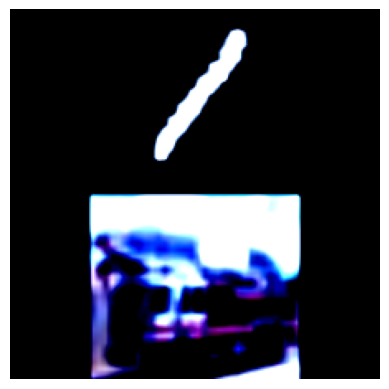

In [21]:
# plot image 
img, y, gl = source_train[-1]
# pad 
# to PIL image 

# img = transforms.ToPILImage()(img)
# img
if is_img and img.dim() == 3 and is_notebook():
    plt.imshow(img.permute(1, 2, 0))
    # show without axis 
    plt.axis('off')
    plt.show()

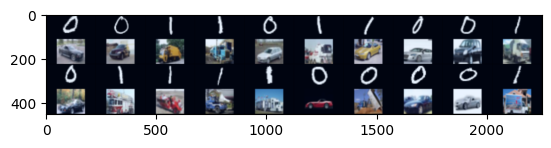

In [22]:
# plot target train images with vision_utils.make_grid
if is_img and img.dim() == 3 and is_notebook():
    img_tensor_grid = torch.stack([target_train[i][0] for i in range(20)])
    grid_img = vision_utils.make_grid(img_tensor_grid, nrow=10, normalize=True, padding=1)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()


In [23]:
class DivisibleBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset_size: int, batch_size: int, shuffle: bool = True):
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.rng = rnd.Random(42)
        
        # Calculate number of complete batches and total samples needed
        self.num_batches = math.ceil(dataset_size / batch_size)
        self.total_size = self.num_batches * batch_size

    def __iter__(self):
        # Generate indices for the entire dataset
        indices = list(range(self.dataset_size))
        
        if self.shuffle:
            # Shuffle all indices
            self.rng.shuffle(indices)
            
        # If we need more indices to make complete batches,
        # randomly sample from existing indices
        if self.total_size > self.dataset_size:
            extra_indices = self.rng.choices(indices, k=self.total_size - self.dataset_size)
            indices.extend(extra_indices)
            
        assert len(indices) == self.total_size
        return iter(indices)

    def __len__(self):
        return self.total_size


In [24]:
source_train_loader = DataLoader(
    source_train, batch_size=conf.batch_size, num_workers=conf.num_workers, 
    sampler=DivisibleBatchSampler(len(source_train), conf.batch_size, shuffle=True), 
)
if len(source_val) > 0:
    source_val_loader = DataLoader(
        source_val, batch_size=conf.batch_size, num_workers=conf.num_workers, 
        sampler=DivisibleBatchSampler(len(source_val), conf.batch_size, shuffle=False)
    )
# NOTE: shuffle "should" be true, but in divdis code its false, and this leads to substantial changes in worst goup result
target_train_loader = DataLoader(
    target_train, batch_size=conf.target_batch_size, num_workers=conf.num_workers, 
    sampler=DivisibleBatchSampler(len(target_train), conf.target_batch_size, shuffle=conf.shuffle_target)
)
if len(target_val) > 0:
    target_val_loader = DataLoader(
        target_val, batch_size=conf.target_batch_size, num_workers=conf.num_workers, 
        sampler=DivisibleBatchSampler(len(target_val), conf.target_batch_size, shuffle=False)
    )
target_test_loader = DataLoader(
    target_test, batch_size=conf.batch_size, num_workers=conf.num_workers, shuffle=False
)

# classifiers
from transformers import get_cosine_schedule_with_warmup
if conf.shared_backbone:
    net = MultiHeadBackbone(model_builder(), classes_per_head, feature_dim, dropout_rate=conf.dropout_rate)
else:
    net = MultiNetModel(model_builder=model_builder, classes_per_head=classes_per_head, feature_dim=feature_dim, dropout_rate=conf.dropout_rate)
net = net.to(conf.device)

# optimizer
if conf.optimizer == "adamw":
    opt = torch.optim.AdamW(net.parameters(), lr=conf.lr, weight_decay=conf.weight_decay)
elif conf.optimizer == "sgd":
    opt = torch.optim.SGD(net.parameters(), lr=conf.lr, weight_decay=conf.weight_decay, momentum=0.9)
else: 
    raise ValueError(f"Optimizer {conf.optimizer} not supported")
num_steps = conf.epochs * len(source_train_loader)
if conf.lr_scheduler == "cosine":       
    scheduler = get_cosine_schedule_with_warmup(
        opt, 
        num_warmup_steps=num_steps * conf.frac_warmup, 
        num_training_steps=num_steps, 
        num_cycles=conf.num_cycles
    )
else: 
    # constant learning rate
    scheduler = None


# loss function
if conf.loss_type == LossType.DIVDIS:
    loss_fn = DivDisLoss(heads=conf.heads)
elif conf.loss_type == LossType.DBAT:
    loss_fn = DBatLoss(heads=conf.heads, n_classes=classes_per_head[0])
elif conf.loss_type == LossType.CONF:
    loss_fn = ConfLoss()
elif conf.loss_type == LossType.SMOOTH:
    loss_fn = SmoothTopLoss(
        criterion=partial(F.binary_cross_entropy_with_logits, reduction='none'), 
        device=conf.device
    )
elif conf.loss_type == LossType.ERM:
    loss_fn = PassThroughLoss()
elif conf.loss_type in [LossType.TOPK, LossType.EXP, LossType.PROB]:
    def get_mix_rate(conf, mix_rate_lb_override=None, group_mix_rate_lb_override=None):
        mix_rate_lower_bound = mix_rate_lb_override if mix_rate_lb_override is not None else conf.mix_rate_lower_bound
        group_mix_rate_lower_bounds = group_mix_rate_lb_override if group_mix_rate_lb_override is not None else conf.group_mix_rate_lower_bounds
        if conf.aggregate_mix_rate:
            mix_rate = mix_rate_lower_bound
            group_mix_rates = None
        elif conf.group_mix_rate_lower_bounds is not None:
            mix_rate = None 
            group_mix_rates = group_mix_rate_lower_bounds
        else:
            mix_rate = None 
            if conf.dataset == "multi-nli" and conf.use_group_labels:
                ood_groups = [(0, 1), (1, 0), (2, 0)]
            else: 
                mix_rate_cls_per_head = classes_per_head 
                if conf.binary:
                    mix_rate_cls_per_head = [2 for _ in classes_per_head]
                ood_groups = [gl for gl in feature_label_ls(mix_rate_cls_per_head)
                            if any(gl[0] != gl[i] for i in range(1, len(gl)))]
            group_mix_rates = {group: mix_rate_lower_bound / len(ood_groups) for group in ood_groups}
        return mix_rate, group_mix_rates
    
    mix_rate, group_mix_rates = get_mix_rate(conf)

    loss_fn = ACELoss(
        classes_per_head=classes_per_head,
        mode=conf.loss_type.value, 
        mix_rate=mix_rate,
        group_mix_rates=group_mix_rates,
        disagree_only=conf.disagree_only,
        device=conf.device, 
        uncertainty_threshold=conf.uncertain_threshold
    )
else:
    raise ValueError(f"Loss type {conf.loss_type} not supported")


# Plot Activations

In [25]:
# visualize data using first two principle componets of final layer activations
if conf.plot_activations and conf.shared_backbone:
    model = model_builder()
    model = model.to(conf.device)
    test_acts, test_labels = get_acts_and_labels(model, target_test_loader, conf.device)
    test_labels = test_labels.to('cpu')
    pca_fig, pca_acts, pca_reducer = plot_activations(
        activations=test_acts, labels=test_labels, 
        classes_per_feature=classes_per_feat, transform="pca"
    )
    umap_fig, umap_acts, umap_reducer = plot_activations(
        activations=test_acts, labels=test_labels, 
        classes_per_feature=classes_per_feat, transform="umap"
    )
    pca_fig.savefig(f"{exp_dir}/activations_pretrain_pca.png")
    pca_fig.savefig(f"{exp_dir}/activations_pretrain_pca.svg")
    umap_fig.savefig(f"{exp_dir}/activations_pretrain_umap.png")
    umap_fig.savefig(f"{exp_dir}/activations_pretrain_umap.svg")
    np.save(f"{exp_dir}/activations_pretrain_pca.npy", pca_acts)
    np.save(f"{exp_dir}/activations_pretrain_umap.npy", umap_acts)
    

In [26]:
# fit linear probe 
if conf.plot_activations and conf.shared_backbone:
    train_acts, train_labels = get_acts_and_labels(model, target_train_loader, conf.device)
    probe_acc, probe_acc_alt = compute_probe_acc(train_acts, train_labels, test_acts, test_labels, classes_per_feat)
    print(f"Accuracy: {probe_acc:.4f}")
    print(f"Alt Accuracy: {probe_acc_alt:.4f}")
    # nah I'll just try to picke the umap

# Train

In [27]:
def compute_src_losses(logits, y, gl):
    logits_by_head = torch.split(logits, classes_per_head, dim=-1)
    labels_by_head = [y, y] if not conf.use_group_labels else [gl[:, 0], gl[:, 1]]

    if conf.binary: # NOTE: not currently supported
        losses = [F.binary_cross_entropy_with_logits(logit.squeeze(), y.squeeze().to(torch.float32)) 
                  for logit, y in zip(logits_by_head, labels_by_head)]
    else:
        assert logits_by_head[0].shape == (logits.size(0), classes_per_head[0]), logits_by_head[0].shape
        losses = [F.cross_entropy(logit.squeeze(), y.squeeze().to(torch.long)) 
                  for logit, y in zip(logits_by_head, labels_by_head)]
    return losses

# TODO: fix
def compute_corrects(logits: torch.Tensor, y: torch.Tensor, binary: bool):
    if binary: # NOTE: not currently supported
        return ((logits.squeeze() > 0) == y.flatten()).sum().item()
    else:
        return (logits.argmax(dim=-1) == y).sum().item()
        

In [28]:
def eval(model, loader, device, loss_fn, use_labels=False, stage: str = "Evaluating"): 
    group_label_ls = feature_label_ls(classes_per_feat)
    # e.g. for classes per_head = [3,2]
    # group_label_ls = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
    
    # loss 
    losses = []

    # accuracy 
    total_corrects_by_groups = {
        group_label: torch.zeros(conf.heads)
        for group_label in group_label_ls
    }
    total_corrects_alt_by_groups = {
        group_label: torch.zeros(conf.heads)
        for group_label in group_label_ls
    }
    total_samples = 0
    total_samples_by_groups = {
        group_label: 0
        for group_label in group_label_ls
    }
    
    with torch.no_grad():
        for x, y, gl in tqdm(loader, desc=stage):
            x, y, gl = to_device(x, y, gl, conf.device)
            logits = model(x)
            # print(test_logits.shape)
            total_samples += logits.size(0)
            if use_labels and loss_fn is not None:
                loss = loss_fn(logits, y, gl)
            elif loss_fn is not None:
                loss = loss_fn(logits)
            else: 
                loss = torch.tensor(0.0, device=conf.device)
            if torch.isnan(loss):
                print(f"Warning: Nan Loss (likely due to batch size and target loss) "
                f"Batch size: {logits.size(0)}, Loss: {conf.loss_type}")
            else:
                losses.append(loss)

            # parition instances into groups based on group labels 
            logits_by_group = {}
            for group_label in group_label_ls:
                group_label_mask = torch.all(gl == torch.tensor(group_label).to(device), dim=1)
                # print("group label mask", group_label_mask.shape)
                logits_by_group[group_label] = logits[group_label_mask]
            # print("group logit shapes", [v.shape for v in logits_by_group.values()])
            
            for group_label, group_logits in logits_by_group.items():
                num_examples_group = group_logits.size(0)
                total_samples_by_groups[group_label] += num_examples_group
                group_labels = torch.tensor(group_label).repeat(num_examples_group, 1).to(device)
                group_logits_by_head = torch.split(group_logits, classes_per_head, dim=-1)
                for i in range(conf.heads):
                    if conf.use_group_labels:
                        total_corrects_by_groups[group_label][i] += compute_corrects(group_logits_by_head[i], group_labels[:, i], conf.binary)
                    else:
                        total_corrects_by_groups[group_label][i] += compute_corrects(group_logits_by_head[i], group_labels[:, 0], conf.binary)
                        total_corrects_alt_by_groups[group_label][i] += compute_corrects(group_logits_by_head[i], group_labels[:, 1], conf.binary)
    
    total_corrects = torch.stack([gl_corrects for gl_corrects in total_corrects_by_groups.values()], dim=0).sum(dim=0)
    if not conf.use_group_labels:
        total_corrects_alt = torch.stack([gl_corrects for gl_corrects in total_corrects_alt_by_groups.values()], dim=0).sum(dim=0)

    # average metrics
    metrics = {}
    for i in range(conf.heads):
        metrics[f"acc_{i}"] = (total_corrects[i] / total_samples).item()
        if not conf.use_group_labels:
            metrics[f"acc_alt_{i}"] = (total_corrects_alt[i] / total_samples).item()
    
    if loss_fn is not None:
        metrics["loss"] = torch.mean(torch.tensor(losses)).item()
    # group acc per head
    for group_label in group_label_ls:
        for i in range(conf.heads): 
            metrics[f"acc_{i}_{group_label}"] = (total_corrects_by_groups[group_label][i] / total_samples_by_groups[group_label]).item()
            if not conf.use_group_labels:
                metrics[f"acc_alt_{i}_{group_label}"] = (total_corrects_alt_by_groups[group_label][i] / total_samples_by_groups[group_label]).item()
    # worst group acc per head
    for i in range(conf.heads):
        metrics[f"worst_acc_{i}"] = min([metrics[f"acc_{i}_{group_label}"] for group_label in group_label_ls])

    # add group counts 
    for group_label in group_label_ls:
        metrics[f"count_{group_label}"] = total_samples_by_groups[group_label]

    return metrics

In [29]:
logger = Logger(exp_dir)
if conf.plot_activations and conf.shared_backbone:   
    logger.add_scalar("test", "probe_acc", probe_acc, -1)
    logger.add_scalar("test", "probe_acc_alt", probe_acc_alt, -1)

In [30]:
import copy
valid_loss_fn = loss_fn 
if isinstance(loss_fn, ACELoss) and conf.mix_rate_schedule is not None:
    print('hello')
    valid_loss_fn = copy.deepcopy(loss_fn)


hello


In [31]:
def get_cur_mix_rate(conf, epoch): 
    cur_mix_rate = None
    cur_group_mix_rates = None
    if epoch < conf.mix_rate_t0: # set to 0
        if conf.mix_rate_lower_bound is not None:
            cur_mix_rate = 0 
        if conf.group_mix_rate_lower_bounds is not None:
            cur_group_mix_rates = {group: 0 for group in conf.group_mix_rate_lower_bounds.keys()}
    elif epoch >= conf.mix_rate_t1: # set to lower bound
        if conf.mix_rate_lower_bound is not None:
            cur_mix_rate = conf.mix_rate_lower_bound
        if conf.group_mix_rate_lower_bounds is not None:
            cur_group_mix_rates = {group: conf.group_mix_rate_lower_bounds[group] for group in conf.group_mix_rate_lower_bounds.keys()}
    else: # set to linear schedule
        if conf.mix_rate_lower_bound is not None:
            cur_mix_rate = conf.mix_rate_lower_bound * (epoch - conf.mix_rate_t0) / (conf.mix_rate_t1 - conf.mix_rate_t0)
        if conf.group_mix_rate_lower_bounds is not None:
            cur_group_mix_rates = {group: conf.group_mix_rate_lower_bounds[group] * (epoch - conf.mix_rate_t0) / (conf.mix_rate_t1 - conf.mix_rate_t0) for group in conf.group_mix_rate_lower_bounds.keys()}
    return cur_mix_rate, cur_group_mix_rates


In [32]:
# TODO: change diciotary values to source loss, target loss
from itertools import cycle
try:
    if conf.freeze_heads:
        # freeze first head (for dbat)
        net.freeze_head(0)
    total_steps = 0
    for epoch in range(conf.epochs):
        train_loader = zip(source_train_loader, cycle(target_train_loader))
        loader_len = len(source_train_loader)
        ### Train
        # mix rate schedule 
        if isinstance(loss_fn, ACELoss):
            if conf.mix_rate_schedule == "linear" and conf.mix_rate_interval_frac is None:
                cur_mix_rate, cur_group_mix_rates = get_cur_mix_rate(conf, epoch)
                _, group_mix_rates = get_mix_rate(conf, mix_rate_lb_override=cur_mix_rate, group_mix_rate_lb_override=cur_group_mix_rates)
                loss_fn.group_mix_rates = group_mix_rates
        
        for batch_idx, (source_batch, target_batch) in tqdm(enumerate(train_loader), desc="Source train", total=loader_len):
            # update mix rate schedule
            if isinstance(loss_fn, ACELoss):
                if conf.mix_rate_schedule == "linear" and conf.mix_rate_interval_frac is not None:
                    if total_steps % int(num_steps * conf.mix_rate_interval_frac) == 0:
                        cur_mix_rate = conf.mix_rate_lower_bound * (total_steps / num_steps) if conf.mix_rate_lower_bound is not None else None
                        cur_group_mix_rates = {group: conf.group_mix_rate_lower_bounds[group] * (total_steps / num_steps) for group in conf.group_mix_rate_lower_bounds.keys()} if conf.group_mix_rate_lower_bounds is not None else None
                        _, group_mix_rates = get_mix_rate(conf, mix_rate_lb_override=cur_mix_rate, group_mix_rate_lb_override=cur_group_mix_rates)
                        print("updating mix rate", "steps", total_steps, "mix rate", cur_mix_rate)
                        loss_fn.group_mix_rates = group_mix_rates
            # freeze heads for dbat
            if conf.freeze_heads and epoch == conf.head_1_epochs: 
                net.unfreeze_head(0)
                net.freeze_head(1)
            # source
            x, y, gl = to_device(*source_batch, conf.device)
            logits = net(x)
            losses = compute_src_losses(logits, y, gl)
            xent = torch.mean(torch.stack(losses))
            logger.add_scalar("train", "source_loss", xent.item(), epoch * loader_len + batch_idx)
            
            # target
            target_x, target_y, target_gl = to_device(*target_batch, conf.device)
            if conf.loss_type == LossType.TOPK and conf.mc_dropout:
                target_logits, target_logit_samples = net(target_x, n_samples=conf.mc_dropout_n)
                target_loss, group_uncertainties = loss_fn(target_logits, mc_samples=target_logit_samples)
                # log average uncertainty per group, and fraction of instances in each group with uncertainty above threshold
                for group, uncertainty in group_uncertainties.items():
                    mean_uncertainty = uncertainty.mean().item()
                    frac_uncertainty = (uncertainty > conf.uncertain_threshold).float().mean().item()
                    print(f"target uncertainty {group}: {mean_uncertainty}, {frac_uncertainty}")
                    logger.add_scalar("train", f"target_uncertainty_{group}", mean_uncertainty, epoch * loader_len + batch_idx)
                    logger.add_scalar("train", f"target_uncertainty_{group}_frac", frac_uncertainty, epoch * loader_len + batch_idx)
            else:
                target_logits = net(target_x)
            
                      
            
            logger.add_scalar("train", "target_loss", target_loss.item(), epoch * loader_len + batch_idx)
            logger.add_scalar("train", "weighted_target_loss", conf.aux_weight * target_loss.item(), epoch * loader_len + batch_idx, to_metrics=False, to_tb=True)
            # don't compute target loss before second head begins training
            if conf.freeze_heads and epoch < conf.head_1_epochs: 
                target_loss = torch.tensor(0.0, device=conf.device)
            
            # full loss 
            full_loss = conf.source_weight * xent + conf.aux_weight * target_loss
            logger.add_scalar("train", "loss", full_loss.item(), epoch * loader_len + batch_idx)
            
            # backprop
            opt.zero_grad()
            full_loss.backward()
            opt.step()
            if scheduler is not None:
                scheduler.step()
            total_steps += 1
        
        # eval
        if (epoch + 1) % 1 == 0:
            net.eval()
            ### Validation 
           
            # source
            total_val_loss = 0.0
            total_val_weighted_loss = 0.0
            if len(source_val) > 0:
                src_loss_fn = lambda x, y, gl: sum(compute_src_losses(x, y, gl))
                source_val_metrics = eval(net, source_val_loader, conf.device, src_loss_fn, use_labels=True, stage="Source Val")
                for k, v in source_val_metrics.items():
                    if 'count' not in k:
                        logger.add_scalar("val", f"source_{k}", v, epoch)
                total_val_loss += source_val_metrics["loss"]
                total_val_weighted_loss += total_val_loss
            # target
            weighted_target_val_loss = 0.0
            if len(target_val) > 0:  
                target_val_metrics = eval(net, target_val_loader, conf.device, valid_loss_fn, use_labels=False, stage="Target Val")
                for k, v in target_val_metrics.items():
                    if 'count' not in k:
                        logger.add_scalar("val", f"target_{k}", v, epoch)
                weighted_target_val_loss = target_val_metrics["loss"] * conf.aux_weight
                logger.add_scalar("val", "target_weighted_loss", weighted_target_val_loss, epoch)
                total_val_loss += target_val_metrics["loss"]    
                total_val_weighted_loss += weighted_target_val_loss
            # total
            logger.add_scalar("val", "loss", total_val_loss, epoch)
            logger.add_scalar("val", "weighted_loss", total_val_weighted_loss, epoch)

            ### Test
            target_test_metrics = eval(net, target_test_loader, conf.device, None, use_labels=False, stage="Target Test")
            for k, v in target_test_metrics.items():
                if 'count' not in k:
                    logger.add_scalar("test", k, v, epoch)
            
            # probe acc
            if conf.plot_activations and conf.shared_backbone:
                train_acts, train_labels = get_acts_and_labels(model, target_train_loader, conf.device)
                test_acts, test_labels = get_acts_and_labels(net.backbone, target_test_loader, conf.device)
                probe_acc, probe_acc_alt = compute_probe_acc(train_acts, train_labels, test_acts, test_labels, classes_per_feat)
                logger.add_scalar("test", "probe_acc", probe_acc, epoch)
                logger.add_scalar("test", "probe_acc_alt", probe_acc_alt, epoch)


            ### Print Results
            print(f"Epoch {epoch + 1} Eval Results:")
            # print validation losses
            if len(source_val) > 0:
                print(f"Source validation loss: {logger.metrics['val_source_loss'][-1]:.4f}")
            if len(target_val) > 0:
                print(f"Target validation loss {logger.metrics['val_target_loss'][-1]:.4f}")
            print(f"Validation loss: {logger.metrics['val_loss'][-1]:.4f}")
            print("\n=== Test Accuracies ===")
            # Overall accuracy for each head
            print("\nOverall Accuracies:")
            for i in range(conf.heads):
                print(f"Head {i}:  Main: {logger.metrics[f'test_acc_{i}'][-1]:.4f}" + \
                      (f"  |  Alt: {logger.metrics[f'test_acc_alt_{i}'][-1]:.4f}" if not conf.use_group_labels else ""))
            # Worst group accuracy for each head
            print("\nWorst Group Accuracies:")
            for i in range(conf.heads):
                print(f"Head {i}:  Worst: {logger.metrics[f'test_worst_acc_{i}'][-1]:.4f}")
            # Group-wise accuracies
            print("\nGroup-wise Accuracies:")
            for group_label in feature_label_ls(classes_per_feat):
                print(f"\nGroup {group_label}, count: {target_test_metrics[f'count_{group_label}']}:")
                for i in range(conf.heads):
                    print(f"Head {i}:  Main: {logger.metrics[f'test_acc_{i}_{group_label}'][-1]:.4f}" + \
                          (f"  |  Alt: {logger.metrics[f'test_acc_alt_{i}_{group_label}'][-1]:.4f}" if not conf.use_group_labels else ""))


            # plot activations if lowest validation loss
            if logger.metrics["val_loss"][-1] == min(logger.metrics["val_loss"]):
                # plot activations 
                if conf.plot_activations and conf.shared_backbone:   
                    # get activations 
                    activations, labels = get_acts_and_labels(net.backbone, target_test_loader, conf.device)
                    labels = labels.to('cpu')
                    pca_fig, pca_acts, pca_reducer = plot_activations(
                        activations=activations, labels=labels, 
                        classes_per_feature=classes_per_feat, transform="pca"
                    )
                    umap_fig, umap_acts, umap_reducer = plot_activations(
                        activations=activations, labels=labels, 
                        classes_per_feature=classes_per_feat, transform="umap"
                    )
                    pca_fig.savefig(f"{exp_dir}/activations_{epoch}_pca.png")
                    pca_fig.savefig(f"{exp_dir}/activations_{epoch}_pca.svg")
                    umap_fig.savefig(f"{exp_dir}/activations_{epoch}_umap.png")
                    umap_fig.savefig(f"{exp_dir}/activations_{epoch}_umap.svg")
                    np.save(f"{exp_dir}/activations_{epoch}_pca.npy", pca_acts)
                    np.save(f"{exp_dir}/activations_{epoch}_umap.npy", umap_acts)
                    plt.close(pca_fig)
                    plt.close(umap_fig)
            # plot average uncertainty per group
            # group_certainties = {}
            # for group in feature_label_ls(classes_per_feat):
            #     group_certainties[group] = logger.metrics[f"target_uncertainty_{group}_frac"]
            #     # plot average uncertainty per group
            #     plt.figure(figsize=(10, 5))
            #     plt.bar(range(len(group_certainties)), list(group_certainties.values()), tick_label=list(group_certainties.keys()))
            #     plt.xlabel("Group")
            #     plt.ylabel("Average Uncertainty")
            #     plt.title("Average Uncertainty per Group")
            #     plt.show()
            
            
            net.train()
finally:
    logger.flush()

Source train:   0%|          | 0/32 [00:00<?, ?it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:   6%|▋         | 2/32 [00:01<00:14,  2.12it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:   9%|▉         | 3/32 [00:01<00:10,  2.85it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  12%|█▎        | 4/32 [00:01<00:08,  3.42it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  16%|█▌        | 5/32 [00:01<00:07,  3.83it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  19%|█▉        | 6/32 [00:01<00:06,  4.16it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  22%|██▏       | 7/32 [00:02<00:05,  4.36it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  25%|██▌       | 8/32 [00:02<00:05,  4.53it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  28%|██▊       | 9/32 [00:02<00:04,  4.65it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  31%|███▏      | 10/32 [00:02<00:04,  4.72it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  34%|███▍      | 11/32 [00:02<00:04,  4.75it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  38%|███▊      | 12/32 [00:03<00:04,  4.81it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  41%|████      | 13/32 [00:03<00:03,  4.81it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  44%|████▍     | 14/32 [00:03<00:03,  4.84it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  47%|████▋     | 15/32 [00:03<00:03,  4.86it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  50%|█████     | 16/32 [00:03<00:03,  4.90it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  53%|█████▎    | 17/32 [00:04<00:03,  4.85it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  56%|█████▋    | 18/32 [00:04<00:02,  4.90it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  59%|█████▉    | 19/32 [00:04<00:02,  4.91it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  62%|██████▎   | 20/32 [00:04<00:02,  4.88it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  66%|██████▌   | 21/32 [00:04<00:02,  4.90it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  69%|██████▉   | 22/32 [00:05<00:02,  4.86it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  72%|███████▏  | 23/32 [00:05<00:01,  4.91it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  75%|███████▌  | 24/32 [00:05<00:01,  4.89it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  78%|███████▊  | 25/32 [00:05<00:01,  4.90it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  81%|████████▏ | 26/32 [00:06<00:01,  4.91it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  84%|████████▍ | 27/32 [00:06<00:01,  4.88it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  88%|████████▊ | 28/32 [00:06<00:00,  4.92it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  91%|█████████ | 29/32 [00:06<00:00,  4.89it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  94%|█████████▍| 30/32 [00:06<00:00,  4.91it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  97%|█████████▋| 31/32 [00:07<00:00,  4.88it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Target Test: 100%|██████████| 31/31 [00:01<00:00, 24.12it/s]

Epoch 1 Eval Results:
Source validation loss: 0.0075
Target validation loss 11.4410
Validation loss: 11.4485

=== Test Accuracies ===

Overall Accuracies:
Head 0:  Main: 0.5000  |  Alt: 1.0000
Head 1:  Main: 0.5000  |  Alt: 1.0000

Worst Group Accuracies:
Head 0:  Worst: 0.0000
Head 1:  Worst: 0.0000

Group-wise Accuracies:

Group (0, 0), count: 245:
Head 0:  Main: 1.0000  |  Alt: 1.0000
Head 1:  Main: 1.0000  |  Alt: 1.0000

Group (0, 1), count: 245:
Head 0:  Main: 0.0000  |  Alt: 1.0000
Head 1:  Main: 0.0000  |  Alt: 1.0000

Group (1, 0), count: 245:
Head 0:  Main: 0.0000  |  Alt: 1.0000
Head 1:  Main: 0.0000  |  Alt: 1.0000

Group (1, 1), count: 245:
Head 0:  Main: 1.0000  |  Alt: 1.0000
Head 1:  Main: 1.0000  |  Alt: 1.0000



Source train:   3%|▎         | 1/32 [00:00<00:03,  8.27it/s]

target uncertainty (0, 1): 0.008750000037252903, 0.046875
target uncertainty (1, 0): 0.007500000298023224, 0.03125


Source train:   6%|▋         | 2/32 [00:00<00:05,  5.90it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:   9%|▉         | 3/32 [00:00<00:05,  5.34it/s]

target uncertainty (0, 1): 0.009062499739229679, 0.03125
target uncertainty (1, 0): 0.007500000298023224, 0.03125


Source train:  12%|█▎        | 4/32 [00:00<00:05,  5.16it/s]

target uncertainty (0, 1): 0.024375000968575478, 0.109375
target uncertainty (1, 0): 0.021562499925494194, 0.09375


Source train:  16%|█▌        | 5/32 [00:00<00:05,  5.06it/s]

target uncertainty (0, 1): 0.007500000298023224, 0.03125
target uncertainty (1, 0): 0.009062499739229679, 0.03125


Source train:  19%|█▉        | 6/32 [00:01<00:05,  4.99it/s]

target uncertainty (0, 1): 0.01718750037252903, 0.09375
target uncertainty (1, 0): 0.010000000707805157, 0.0625


Source train:  22%|██▏       | 7/32 [00:01<00:05,  4.94it/s]

target uncertainty (0, 1): 0.011874999850988388, 0.046875
target uncertainty (1, 0): 0.018125001341104507, 0.078125


Source train:  25%|██▌       | 8/32 [00:01<00:04,  4.89it/s]

target uncertainty (0, 1): 0.016249999403953552, 0.0625
target uncertainty (1, 0): 0.0240625012665987, 0.109375


Source train:  28%|██▊       | 9/32 [00:01<00:04,  4.89it/s]

target uncertainty (0, 1): 0.025624999776482582, 0.09375
target uncertainty (1, 0): 0.025312500074505806, 0.109375


Source train:  31%|███▏      | 10/32 [00:01<00:04,  4.87it/s]

target uncertainty (0, 1): 0.030937500298023224, 0.140625
target uncertainty (1, 0): 0.030625000596046448, 0.09375


Source train:  34%|███▍      | 11/32 [00:02<00:04,  4.88it/s]

target uncertainty (0, 1): 0.01718750037252903, 0.0625
target uncertainty (1, 0): 0.029374999925494194, 0.109375


Source train:  38%|███▊      | 12/32 [00:02<00:04,  4.89it/s]

target uncertainty (0, 1): 0.03125, 0.125
target uncertainty (1, 0): 0.028437500819563866, 0.109375


Source train:  41%|████      | 13/32 [00:02<00:03,  4.89it/s]

target uncertainty (0, 1): 0.015937499701976776, 0.046875
target uncertainty (1, 0): 0.019375000149011612, 0.078125


Source train:  44%|████▍     | 14/32 [00:02<00:03,  4.90it/s]

target uncertainty (0, 1): 0.020937498658895493, 0.078125
target uncertainty (1, 0): 0.023125000298023224, 0.09375


Source train:  47%|████▋     | 15/32 [00:02<00:03,  4.87it/s]

target uncertainty (0, 1): 0.015312501229345798, 0.0625
target uncertainty (1, 0): 0.017499998211860657, 0.0625


Source train:  50%|█████     | 16/32 [00:03<00:03,  4.86it/s]

target uncertainty (0, 1): 0.018124999478459358, 0.078125
target uncertainty (1, 0): 0.018124999478459358, 0.0625


Source train:  53%|█████▎    | 17/32 [00:03<00:03,  4.89it/s]

target uncertainty (0, 1): 0.014687500894069672, 0.0625
target uncertainty (1, 0): 0.019062500447034836, 0.078125


Source train:  56%|█████▋    | 18/32 [00:03<00:02,  4.88it/s]

target uncertainty (0, 1): 0.004999999888241291, 0.03125
target uncertainty (1, 0): 0.0, 0.0


Source train:  59%|█████▉    | 19/32 [00:03<00:02,  4.90it/s]

target uncertainty (0, 1): 0.004999999888241291, 0.03125
target uncertainty (1, 0): 0.012187500484287739, 0.0625


Source train:  62%|██████▎   | 20/32 [00:04<00:02,  4.91it/s]

target uncertainty (0, 1): 0.006562500260770321, 0.03125
target uncertainty (1, 0): 0.019999999552965164, 0.0625


Source train:  66%|██████▌   | 21/32 [00:04<00:02,  4.87it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.009062499739229679, 0.03125


Source train:  69%|██████▉   | 22/32 [00:04<00:02,  4.87it/s]

target uncertainty (0, 1): 0.00937500037252903, 0.03125
target uncertainty (1, 0): 0.0078125, 0.03125


Source train:  72%|███████▏  | 23/32 [00:04<00:01,  4.86it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.01406249962747097, 0.046875


Source train:  75%|███████▌  | 24/32 [00:04<00:01,  4.87it/s]

target uncertainty (0, 1): 0.0028124996460974216, 0.0
target uncertainty (1, 0): 0.0028124996460974216, 0.0


Source train:  78%|███████▊  | 25/32 [00:05<00:01,  4.88it/s]

target uncertainty (0, 1): 0.015312500298023224, 0.0625
target uncertainty (1, 0): 0.008124999701976776, 0.015625


Source train:  81%|████████▏ | 26/32 [00:05<00:01,  4.86it/s]

target uncertainty (0, 1): 0.016249999403953552, 0.0625
target uncertainty (1, 0): 0.009687500074505806, 0.046875


Source train:  84%|████████▍ | 27/32 [00:05<00:01,  4.92it/s]

target uncertainty (0, 1): 0.011250000447034836, 0.046875
target uncertainty (1, 0): 0.011874999850988388, 0.03125


Source train:  88%|████████▊ | 28/32 [00:05<00:00,  4.87it/s]

target uncertainty (0, 1): 0.010312500409781933, 0.046875
target uncertainty (1, 0): 0.007187499664723873, 0.03125


Source train:  91%|█████████ | 29/32 [00:05<00:00,  4.77it/s]

target uncertainty (0, 1): 0.011874999850988388, 0.046875
target uncertainty (1, 0): 0.008437499403953552, 0.03125


Source train:  94%|█████████▍| 30/32 [00:06<00:00,  4.79it/s]

target uncertainty (0, 1): 0.019999999552965164, 0.078125
target uncertainty (1, 0): 0.013749999925494194, 0.046875


Source train:  97%|█████████▋| 31/32 [00:06<00:00,  4.82it/s]

target uncertainty (0, 1): 0.013749999925494194, 0.0625
target uncertainty (1, 0): 0.015937501564621925, 0.078125


Source train: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


target uncertainty (0, 1): 0.009687500074505806, 0.046875
target uncertainty (1, 0): 0.014999999664723873, 0.0625


Target Test: 100%|██████████| 31/31 [00:01<00:00, 24.23it/s]

Epoch 2 Eval Results:
Source validation loss: 1.1806
Target validation loss 1.0857
Validation loss: 2.2664

=== Test Accuracies ===

Overall Accuracies:
Head 0:  Main: 0.5408  |  Alt: 0.7816
Head 1:  Main: 0.4571  |  Alt: 0.7612

Worst Group Accuracies:
Head 0:  Worst: 0.0000
Head 1:  Worst: 0.0408

Group-wise Accuracies:

Group (0, 0), count: 245:
Head 0:  Main: 1.0000  |  Alt: 1.0000
Head 1:  Main: 0.9551  |  Alt: 0.9551

Group (0, 1), count: 245:
Head 0:  Main: 0.5184  |  Alt: 0.4816
Head 1:  Main: 0.3510  |  Alt: 0.6490

Group (1, 0), count: 245:
Head 0:  Main: 0.0000  |  Alt: 1.0000
Head 1:  Main: 0.0408  |  Alt: 0.9592

Group (1, 1), count: 245:
Head 0:  Main: 0.6449  |  Alt: 0.6449
Head 1:  Main: 0.4816  |  Alt: 0.4816



Source train:   3%|▎         | 1/32 [00:00<00:03,  8.86it/s]

target uncertainty (0, 1): 0.024062499403953552, 0.09375
target uncertainty (1, 0): 0.005624999292194843, 0.0


Source train:   6%|▋         | 2/32 [00:00<00:04,  6.01it/s]

target uncertainty (0, 1): 0.010624999180436134, 0.03125
target uncertainty (1, 0): 0.007187500596046448, 0.03125


Source train:   9%|▉         | 3/32 [00:00<00:05,  5.38it/s]

target uncertainty (0, 1): 0.0240625012665987, 0.125
target uncertainty (1, 0): 0.01406249962747097, 0.0625


Source train:  12%|█▎        | 4/32 [00:00<00:05,  5.15it/s]

target uncertainty (0, 1): 0.010312499478459358, 0.015625
target uncertainty (1, 0): 0.01718750037252903, 0.0625


Source train:  16%|█▌        | 5/32 [00:00<00:05,  5.03it/s]

target uncertainty (0, 1): 0.02812500111758709, 0.125
target uncertainty (1, 0): 0.017812499776482582, 0.078125


Source train:  19%|█▉        | 6/32 [00:01<00:05,  4.98it/s]

target uncertainty (0, 1): 0.007187499664723873, 0.03125
target uncertainty (1, 0): 0.018437499180436134, 0.0625


Source train:  22%|██▏       | 7/32 [00:01<00:05,  4.92it/s]

target uncertainty (0, 1): 0.015312500298023224, 0.0625
target uncertainty (1, 0): 0.0, 0.0


Source train:  25%|██▌       | 8/32 [00:01<00:04,  4.95it/s]

target uncertainty (0, 1): 0.014062500558793545, 0.0625
target uncertainty (1, 0): 0.0, 0.0


Source train:  28%|██▊       | 9/32 [00:01<00:04,  4.92it/s]

target uncertainty (0, 1): 0.012500000186264515, 0.0625
target uncertainty (1, 0): 0.008750000037252903, 0.046875


Source train:  31%|███▏      | 10/32 [00:01<00:04,  4.87it/s]

target uncertainty (0, 1): 0.011562500149011612, 0.046875
target uncertainty (1, 0): 0.0, 0.0


Source train:  34%|███▍      | 11/32 [00:02<00:04,  4.84it/s]

target uncertainty (0, 1): 0.01249999925494194, 0.046875
target uncertainty (1, 0): 0.01656249910593033, 0.0625


Source train:  38%|███▊      | 12/32 [00:02<00:04,  4.91it/s]

target uncertainty (0, 1): 0.019062500447034836, 0.078125
target uncertainty (1, 0): 0.009687500074505806, 0.046875


Source train:  41%|████      | 13/32 [00:02<00:03,  4.87it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.013437500223517418, 0.0625


Source train:  44%|████▍     | 14/32 [00:02<00:03,  4.88it/s]

target uncertainty (0, 1): 0.009062500670552254, 0.03125
target uncertainty (1, 0): 0.00937500037252903, 0.03125


Source train:  47%|████▋     | 15/32 [00:02<00:03,  4.88it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.008124998770654202, 0.015625


Source train:  50%|█████     | 16/32 [00:03<00:03,  4.87it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.011874999850988388, 0.046875


Source train:  53%|█████▎    | 17/32 [00:03<00:03,  4.91it/s]

target uncertainty (0, 1): 0.004999999888241291, 0.03125
target uncertainty (1, 0): 0.01249999925494194, 0.046875


Source train:  56%|█████▋    | 18/32 [00:03<00:02,  4.91it/s]

target uncertainty (0, 1): 0.0028124996460974216, 0.0
target uncertainty (1, 0): 0.0078125, 0.03125


Source train:  59%|█████▉    | 19/32 [00:03<00:02,  4.88it/s]

target uncertainty (0, 1): 0.0028124996460974216, 0.0
target uncertainty (1, 0): 0.01656249910593033, 0.078125


Source train:  62%|██████▎   | 20/32 [00:04<00:02,  4.87it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.007187499664723873, 0.03125


Source train:  66%|██████▌   | 21/32 [00:04<00:02,  4.90it/s]

target uncertainty (0, 1): 0.012187499552965164, 0.046875
target uncertainty (1, 0): 0.014687499962747097, 0.046875


Source train:  69%|██████▉   | 22/32 [00:04<00:02,  4.88it/s]

target uncertainty (0, 1): 0.0071875001303851604, 0.03125
target uncertainty (1, 0): 0.01093750074505806, 0.046875


Source train:  72%|███████▏  | 23/32 [00:04<00:01,  4.88it/s]

target uncertainty (0, 1): 0.010312499478459358, 0.046875
target uncertainty (1, 0): 0.014374999329447746, 0.046875


Source train:  75%|███████▌  | 24/32 [00:04<00:01,  4.90it/s]

target uncertainty (0, 1): 0.008437499403953552, 0.03125
target uncertainty (1, 0): 0.012812500819563866, 0.0625


Source train:  78%|███████▊  | 25/32 [00:05<00:01,  4.86it/s]

target uncertainty (0, 1): 0.007500000298023224, 0.03125
target uncertainty (1, 0): 0.005624999292194843, 0.0


Source train:  81%|████████▏ | 26/32 [00:05<00:01,  4.85it/s]

target uncertainty (0, 1): 0.010000000707805157, 0.046875
target uncertainty (1, 0): 0.017812499776482582, 0.0625


Source train:  84%|████████▍ | 27/32 [00:05<00:01,  4.86it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.008437499403953552, 0.03125


Source train:  88%|████████▊ | 28/32 [00:05<00:00,  4.89it/s]

target uncertainty (0, 1): 0.012812499888241291, 0.046875
target uncertainty (1, 0): 0.0, 0.0


Source train:  91%|█████████ | 29/32 [00:05<00:00,  4.88it/s]

target uncertainty (0, 1): 0.0078125, 0.03125
target uncertainty (1, 0): 0.01875000074505806, 0.078125


Source train:  94%|█████████▍| 30/32 [00:06<00:00,  4.85it/s]

target uncertainty (0, 1): 0.0240625012665987, 0.125
target uncertainty (1, 0): 0.011874999850988388, 0.046875


Source train:  97%|█████████▋| 31/32 [00:06<00:00,  4.90it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0028124996460974216, 0.0


Source train: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s]


target uncertainty (0, 1): 0.0028124996460974216, 0.0
target uncertainty (1, 0): 0.007187499664723873, 0.03125


Target Test: 100%|██████████| 31/31 [00:01<00:00, 24.59it/s]

Epoch 3 Eval Results:
Source validation loss: 0.7647
Target validation loss 0.8358
Validation loss: 1.6004

=== Test Accuracies ===

Overall Accuracies:
Head 0:  Main: 0.6143  |  Alt: 0.7776
Head 1:  Main: 0.5010  |  Alt: 0.7806

Worst Group Accuracies:
Head 0:  Worst: 0.1959
Head 1:  Worst: 0.0367

Group-wise Accuracies:

Group (0, 0), count: 245:
Head 0:  Main: 0.9755  |  Alt: 0.9755
Head 1:  Main: 1.0000  |  Alt: 1.0000

Group (0, 1), count: 245:
Head 0:  Main: 0.4776  |  Alt: 0.5224
Head 1:  Main: 0.4041  |  Alt: 0.5959

Group (1, 0), count: 245:
Head 0:  Main: 0.1959  |  Alt: 0.8041
Head 1:  Main: 0.0367  |  Alt: 0.9633

Group (1, 1), count: 245:
Head 0:  Main: 0.8082  |  Alt: 0.8082
Head 1:  Main: 0.5633  |  Alt: 0.5633



Source train:   3%|▎         | 1/32 [00:00<00:03,  8.20it/s]

target uncertainty (0, 1): 0.007500000298023224, 0.015625
target uncertainty (1, 0): 0.0, 0.0


Source train:   6%|▋         | 2/32 [00:00<00:05,  5.89it/s]

target uncertainty (0, 1): 0.01406249962747097, 0.0625
target uncertainty (1, 0): 0.010624999180436134, 0.03125


Source train:   9%|▉         | 3/32 [00:00<00:05,  5.36it/s]

target uncertainty (0, 1): 0.011874998919665813, 0.03125
target uncertainty (1, 0): 0.005624999292194843, 0.0


Source train:  12%|█▎        | 4/32 [00:00<00:05,  5.16it/s]

target uncertainty (0, 1): 0.007812499534338713, 0.03125
target uncertainty (1, 0): 0.0, 0.0


Source train:  16%|█▌        | 5/32 [00:00<00:05,  5.05it/s]

target uncertainty (0, 1): 0.008437500335276127, 0.03125
target uncertainty (1, 0): 0.014999999664723873, 0.046875


Source train:  19%|█▉        | 6/32 [00:01<00:05,  4.98it/s]

target uncertainty (0, 1): 0.013125000521540642, 0.046875
target uncertainty (1, 0): 0.0028124996460974216, 0.0


Source train:  22%|██▏       | 7/32 [00:01<00:05,  4.93it/s]

target uncertainty (0, 1): 0.006562500260770321, 0.03125
target uncertainty (1, 0): 0.0, 0.0


Source train:  25%|██▌       | 8/32 [00:01<00:04,  4.90it/s]

target uncertainty (0, 1): 0.007500000298023224, 0.03125
target uncertainty (1, 0): 0.0, 0.0


Source train:  28%|██▊       | 9/32 [00:01<00:04,  4.89it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.013749998062849045, 0.046875


Source train:  31%|███▏      | 10/32 [00:01<00:04,  4.88it/s]

target uncertainty (0, 1): 0.016562500968575478, 0.078125
target uncertainty (1, 0): 0.007500000298023224, 0.03125


Source train:  34%|███▍      | 11/32 [00:02<00:04,  4.89it/s]

target uncertainty (0, 1): 0.0028124996460974216, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  38%|███▊      | 12/32 [00:02<00:04,  4.87it/s]

target uncertainty (0, 1): 0.014999999664723873, 0.046875
target uncertainty (1, 0): 0.0, 0.0


Source train:  41%|████      | 13/32 [00:02<00:03,  4.88it/s]

target uncertainty (0, 1): 0.009687500074505806, 0.046875
target uncertainty (1, 0): 0.0, 0.0


Source train:  44%|████▍     | 14/32 [00:02<00:03,  4.88it/s]

target uncertainty (0, 1): 0.009999999776482582, 0.03125
target uncertainty (1, 0): 0.0, 0.0


Source train:  47%|████▋     | 15/32 [00:02<00:03,  4.88it/s]

target uncertainty (0, 1): 0.009999999776482582, 0.03125
target uncertainty (1, 0): 0.009062498807907104, 0.03125


Source train:  50%|█████     | 16/32 [00:03<00:03,  4.86it/s]

target uncertainty (0, 1): 0.018437501043081284, 0.078125
target uncertainty (1, 0): 0.011874999850988388, 0.046875


Source train:  53%|█████▎    | 17/32 [00:03<00:03,  4.88it/s]

target uncertainty (0, 1): 0.007187499664723873, 0.03125
target uncertainty (1, 0): 0.0, 0.0


Source train:  56%|█████▋    | 18/32 [00:03<00:02,  4.86it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.007187499664723873, 0.03125


Source train:  59%|█████▉    | 19/32 [00:03<00:02,  4.86it/s]

target uncertainty (0, 1): 0.0028124996460974216, 0.0
target uncertainty (1, 0): 0.010312499478459358, 0.046875


Source train:  62%|██████▎   | 20/32 [00:04<00:02,  4.85it/s]

target uncertainty (0, 1): 0.010312499478459358, 0.046875
target uncertainty (1, 0): 0.008437499403953552, 0.03125


Source train:  66%|██████▌   | 21/32 [00:04<00:02,  4.84it/s]

target uncertainty (0, 1): 0.005312499590218067, 0.015625
target uncertainty (1, 0): 0.006562500260770321, 0.03125


Source train:  69%|██████▉   | 22/32 [00:04<00:02,  4.85it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  72%|███████▏  | 23/32 [00:04<00:01,  4.83it/s]

target uncertainty (0, 1): 0.0053125000558793545, 0.015625
target uncertainty (1, 0): 0.004999999888241291, 0.03125


Source train:  75%|███████▌  | 24/32 [00:04<00:01,  4.81it/s]

target uncertainty (0, 1): 0.013125000521540642, 0.046875
target uncertainty (1, 0): 0.0, 0.0


Source train:  78%|███████▊  | 25/32 [00:05<00:01,  4.87it/s]

target uncertainty (0, 1): 0.010312499478459358, 0.046875
target uncertainty (1, 0): 0.006562500260770321, 0.03125


Source train:  81%|████████▏ | 26/32 [00:05<00:01,  4.85it/s]

target uncertainty (0, 1): 0.014062500558793545, 0.078125
target uncertainty (1, 0): 0.0, 0.0


Source train:  84%|████████▍ | 27/32 [00:05<00:01,  4.86it/s]

target uncertainty (0, 1): 0.013749998062849045, 0.046875
target uncertainty (1, 0): 0.01093750074505806, 0.046875


Source train:  88%|████████▊ | 28/32 [00:05<00:00,  4.85it/s]

target uncertainty (0, 1): 0.0028124996460974216, 0.0
target uncertainty (1, 0): 0.009374999441206455, 0.03125


Source train:  91%|█████████ | 29/32 [00:05<00:00,  4.86it/s]

target uncertainty (0, 1): 0.013437500223517418, 0.0625
target uncertainty (1, 0): 0.017499998211860657, 0.078125


Source train:  94%|█████████▍| 30/32 [00:06<00:00,  4.84it/s]

target uncertainty (0, 1): 0.009687500074505806, 0.046875
target uncertainty (1, 0): 0.007500000298023224, 0.03125


Source train:  97%|█████████▋| 31/32 [00:06<00:00,  4.83it/s]

target uncertainty (0, 1): 0.007500000298023224, 0.03125
target uncertainty (1, 0): 0.0, 0.0


Source train: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


target uncertainty (0, 1): 0.007812499534338713, 0.03125
target uncertainty (1, 0): 0.0078125, 0.03125


Target Test: 100%|██████████| 31/31 [00:01<00:00, 23.52it/s]

Epoch 4 Eval Results:
Source validation loss: 0.8578
Target validation loss 0.7322
Validation loss: 1.5900

=== Test Accuracies ===

Overall Accuracies:
Head 0:  Main: 0.7133  |  Alt: 0.6173
Head 1:  Main: 0.4816  |  Alt: 0.8510

Worst Group Accuracies:
Head 0:  Worst: 0.4776
Head 1:  Worst: 0.0082

Group-wise Accuracies:

Group (0, 0), count: 245:
Head 0:  Main: 0.9633  |  Alt: 0.9633
Head 1:  Main: 1.0000  |  Alt: 1.0000

Group (0, 1), count: 245:
Head 0:  Main: 0.7143  |  Alt: 0.2857
Head 1:  Main: 0.2531  |  Alt: 0.7469

Group (1, 0), count: 245:
Head 0:  Main: 0.4776  |  Alt: 0.5224
Head 1:  Main: 0.0082  |  Alt: 0.9918

Group (1, 1), count: 245:
Head 0:  Main: 0.6980  |  Alt: 0.6980
Head 1:  Main: 0.6653  |  Alt: 0.6653



Source train:   3%|▎         | 1/32 [00:00<00:03,  8.43it/s]

target uncertainty (0, 1): 0.006562500260770321, 0.03125
target uncertainty (1, 0): 0.0078125, 0.03125


Source train:   6%|▋         | 2/32 [00:00<00:05,  5.89it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:   9%|▉         | 3/32 [00:00<00:05,  5.37it/s]

target uncertainty (0, 1): 0.011874999850988388, 0.046875
target uncertainty (1, 0): 0.0, 0.0


Source train:  12%|█▎        | 4/32 [00:00<00:05,  5.14it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  16%|█▌        | 5/32 [00:00<00:05,  5.11it/s]

target uncertainty (0, 1): 0.009062499739229679, 0.03125
target uncertainty (1, 0): 0.009999999776482582, 0.03125


Source train:  19%|█▉        | 6/32 [00:01<00:05,  4.98it/s]

target uncertainty (0, 1): 0.006562500260770321, 0.03125
target uncertainty (1, 0): 0.005312499590218067, 0.015625


Source train:  22%|██▏       | 7/32 [00:01<00:05,  4.97it/s]

target uncertainty (0, 1): 0.010000000707805157, 0.046875
target uncertainty (1, 0): 0.0028124996460974216, 0.0


Source train:  25%|██▌       | 8/32 [00:01<00:04,  4.94it/s]

target uncertainty (0, 1): 0.0053125000558793545, 0.015625
target uncertainty (1, 0): 0.009062498807907104, 0.03125


Source train:  28%|██▊       | 9/32 [00:01<00:04,  4.92it/s]

target uncertainty (0, 1): 0.004999999888241291, 0.03125
target uncertainty (1, 0): 0.008437500335276127, 0.03125


Source train:  31%|███▏      | 10/32 [00:01<00:04,  4.90it/s]

target uncertainty (0, 1): 0.014374999329447746, 0.0625
target uncertainty (1, 0): 0.008437499403953552, 0.03125


Source train:  34%|███▍      | 11/32 [00:02<00:04,  4.88it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.004999999888241291, 0.03125


Source train:  38%|███▊      | 12/32 [00:02<00:04,  4.88it/s]

target uncertainty (0, 1): 0.005312499590218067, 0.015625
target uncertainty (1, 0): 0.010312499478459358, 0.046875


Source train:  41%|████      | 13/32 [00:02<00:03,  4.89it/s]

target uncertainty (0, 1): 0.006562500260770321, 0.03125
target uncertainty (1, 0): 0.004999999888241291, 0.03125


Source train:  44%|████▍     | 14/32 [00:02<00:03,  4.85it/s]

target uncertainty (0, 1): 0.006562500260770321, 0.03125
target uncertainty (1, 0): 0.008437499403953552, 0.03125


Source train:  47%|████▋     | 15/32 [00:02<00:03,  4.86it/s]

target uncertainty (0, 1): 0.010000000707805157, 0.0625
target uncertainty (1, 0): 0.005624999292194843, 0.0


Source train:  50%|█████     | 16/32 [00:03<00:03,  4.85it/s]

target uncertainty (0, 1): 0.0028124996460974216, 0.0
target uncertainty (1, 0): 0.0071875001303851604, 0.03125


Source train:  53%|█████▎    | 17/32 [00:03<00:03,  4.89it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.006562500260770321, 0.03125


Source train:  56%|█████▋    | 18/32 [00:03<00:02,  4.88it/s]

target uncertainty (0, 1): 0.0028124996460974216, 0.0
target uncertainty (1, 0): 0.023749999701976776, 0.09375


Source train:  59%|█████▉    | 19/32 [00:03<00:02,  4.86it/s]

target uncertainty (0, 1): 0.012187499552965164, 0.046875
target uncertainty (1, 0): 0.010312499478459358, 0.03125


Source train:  62%|██████▎   | 20/32 [00:04<00:02,  4.88it/s]

target uncertainty (0, 1): 0.009062498807907104, 0.03125
target uncertainty (1, 0): 0.011874999850988388, 0.03125


Source train:  66%|██████▌   | 21/32 [00:04<00:02,  4.89it/s]

target uncertainty (0, 1): 0.007187499664723873, 0.03125
target uncertainty (1, 0): 0.008437499403953552, 0.03125


Source train:  69%|██████▉   | 22/32 [00:04<00:02,  4.87it/s]

target uncertainty (0, 1): 0.009687500074505806, 0.046875
target uncertainty (1, 0): 0.0028124996460974216, 0.0


Source train:  72%|███████▏  | 23/32 [00:04<00:01,  4.89it/s]

target uncertainty (0, 1): 0.01093750074505806, 0.046875
target uncertainty (1, 0): 0.00937499850988388, 0.015625


Source train:  75%|███████▌  | 24/32 [00:04<00:01,  4.85it/s]

target uncertainty (0, 1): 0.005312499590218067, 0.015625
target uncertainty (1, 0): 0.006562500260770321, 0.03125


Source train:  78%|███████▊  | 25/32 [00:05<00:01,  4.88it/s]

target uncertainty (0, 1): 0.009999999776482582, 0.03125
target uncertainty (1, 0): 0.005312499590218067, 0.015625


Source train:  81%|████████▏ | 26/32 [00:05<00:01,  4.88it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  84%|████████▍ | 27/32 [00:05<00:01,  4.88it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.009687500074505806, 0.046875


Source train:  88%|████████▊ | 28/32 [00:05<00:00,  4.88it/s]

target uncertainty (0, 1): 0.0, 0.0
target uncertainty (1, 0): 0.0, 0.0


Source train:  91%|█████████ | 29/32 [00:05<00:00,  4.88it/s]

target uncertainty (0, 1): 0.007187499664723873, 0.03125
target uncertainty (1, 0): 0.0028124996460974216, 0.0


Source train:  94%|█████████▍| 30/32 [00:06<00:00,  4.86it/s]

target uncertainty (0, 1): 0.008437499403953552, 0.03125
target uncertainty (1, 0): 0.0028124996460974216, 0.0


Source train:  97%|█████████▋| 31/32 [00:06<00:00,  4.88it/s]

target uncertainty (0, 1): 0.009062498807907104, 0.03125
target uncertainty (1, 0): 0.004999999888241291, 0.03125


Source train: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


target uncertainty (0, 1): 0.006562500260770321, 0.03125
target uncertainty (1, 0): 0.0, 0.0


Target Test: 100%|██████████| 31/31 [00:01<00:00, 23.77it/s]

Epoch 5 Eval Results:
Source validation loss: 0.8127
Target validation loss 0.5634
Validation loss: 1.3761

=== Test Accuracies ===

Overall Accuracies:
Head 0:  Main: 0.8031  |  Alt: 0.5153
Head 1:  Main: 0.4816  |  Alt: 0.8633

Worst Group Accuracies:
Head 0:  Worst: 0.6735
Head 1:  Worst: 0.0041

Group-wise Accuracies:

Group (0, 0), count: 245:
Head 0:  Main: 0.9633  |  Alt: 0.9633
Head 1:  Main: 0.9959  |  Alt: 0.9959

Group (0, 1), count: 245:
Head 0:  Main: 0.7714  |  Alt: 0.2286
Head 1:  Main: 0.2327  |  Alt: 0.7673

Group (1, 0), count: 245:
Head 0:  Main: 0.8041  |  Alt: 0.1959
Head 1:  Main: 0.0041  |  Alt: 0.9959

Group (1, 1), count: 245:
Head 0:  Main: 0.6735  |  Alt: 0.6735
Head 1:  Main: 0.6939  |  Alt: 0.6939


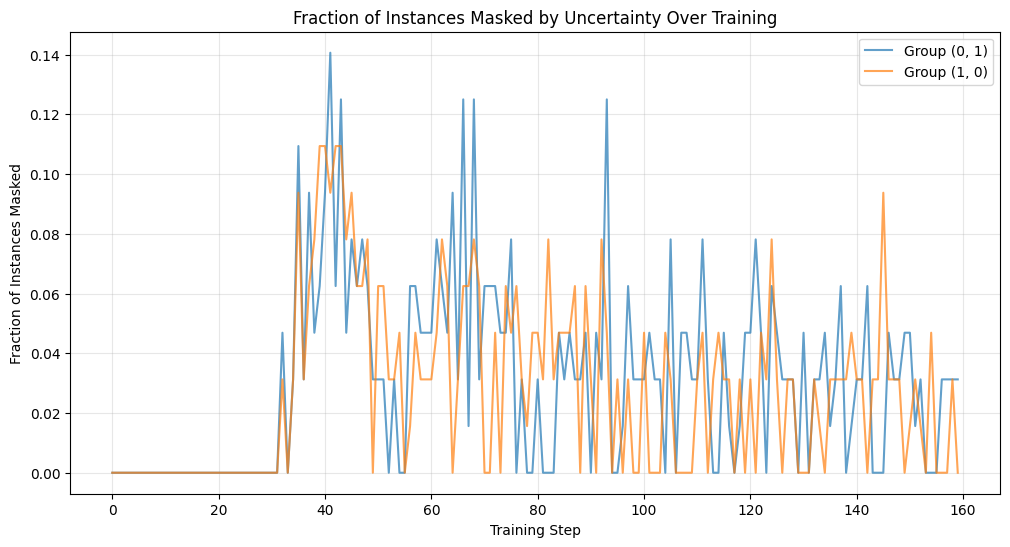

In [33]:
# Plot uncertainty metrics from logger
if conf.loss_type == LossType.TOPK and conf.mc_dropout:
    plt.figure(figsize=(12, 6))
    
    # Get all groups by finding keys that match pattern "train_target_uncertainty_*_frac"
    group_keys = [k for k in logger.metrics.keys() if k.startswith("train_target_uncertainty_") and k.endswith("_frac")]
    group_labels = [k.replace("train_target_uncertainty_", "").replace("_frac", "") for k in group_keys]
    
    # Plot fraction masked over time for each group
    for key, label in zip(group_keys, group_labels):
        fractions = logger.metrics[key]
        steps = range(len(fractions))
        plt.plot(steps, fractions, label=f"Group {label}", alpha=0.7)
    
    plt.xlabel("Training Step")
    plt.ylabel("Fraction of Instances Masked")
    plt.title("Fraction of Instances Masked by Uncertainty Over Training")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # # Save plot
    # plt.savefig(f"{exp_dir}/uncertainty_fractions_over_time.png")
    # plt.savefig(f"{exp_dir}/uncertainty_fractions_over_time.svg")
    # plt.close()

In [34]:
frac_keys

NameError: name 'frac_keys' is not defined

In [42]:
mean_keys

['train_target_uncertainty_(0, 1)', 'train_target_uncertainty_(1, 0)']

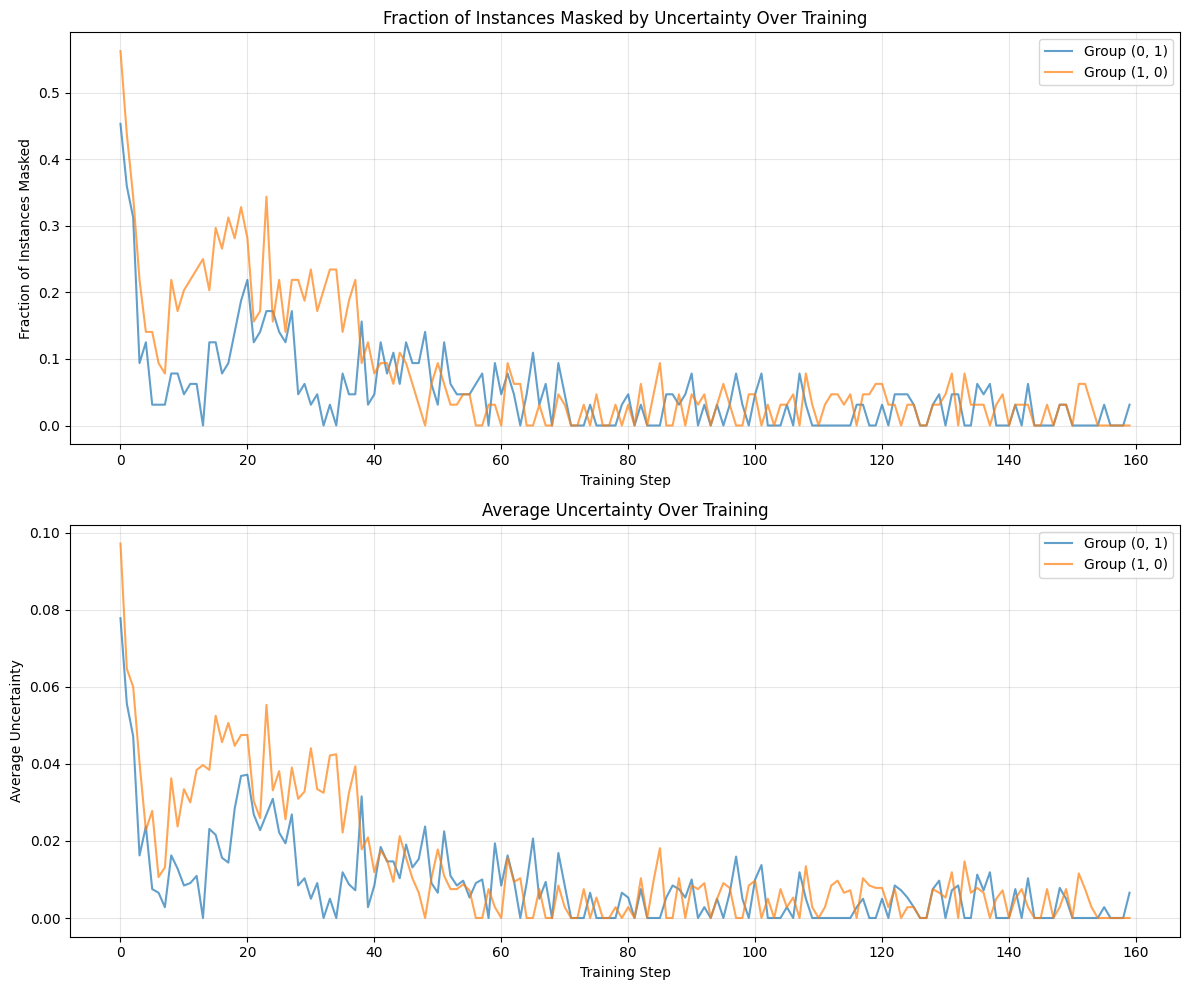

In [ ]:
# Plot uncertainty metrics from logger
if conf.loss_type == LossType.TOPK and conf.mc_dropout:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Get all groups
    frac_keys = [k for k in logger.metrics.keys() if k.startswith("train_target_uncertainty_") and k.endswith("_frac")]
    mean_keys = [k for k in logger.metrics.keys() if k.startswith("train_target_uncertainty_") and not k.endswith("_frac")]
    group_labels = [k.replace("train_target_uncertainty_", "").replace("_frac", "") for k in frac_keys]
    
    # Plot fraction masked over time
    for key, label in zip(frac_keys, group_labels):
        fractions = logger.metrics[key]
        steps = range(len(fractions))
        ax1.plot(steps, fractions, label=f"Group {label}", alpha=0.7)
    
    ax1.set_xlabel("Training Step")
    ax1.set_ylabel("Fraction of Instances Masked")
    ax1.set_title("Fraction of Instances Masked by Uncertainty Over Training")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot average uncertainty over time
    for key, label in zip(mean_keys, group_labels):
        means = logger.metrics[key]
        steps = range(len(means))
        ax2.plot(steps, means, label=f"Group {label}", alpha=0.7)
    
    ax2.set_xlabel("Training Step")
    ax2.set_ylabel("Average Uncertainty")
    ax2.set_title("Average Uncertainty Over Training")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # # Save plots
    # plt.savefig(f"{exp_dir}/uncertainty_metrics_over_time.png")
    # plt.savefig(f"{exp_dir}/uncertainty_metrics_over_time.svg")
    # plt.close()